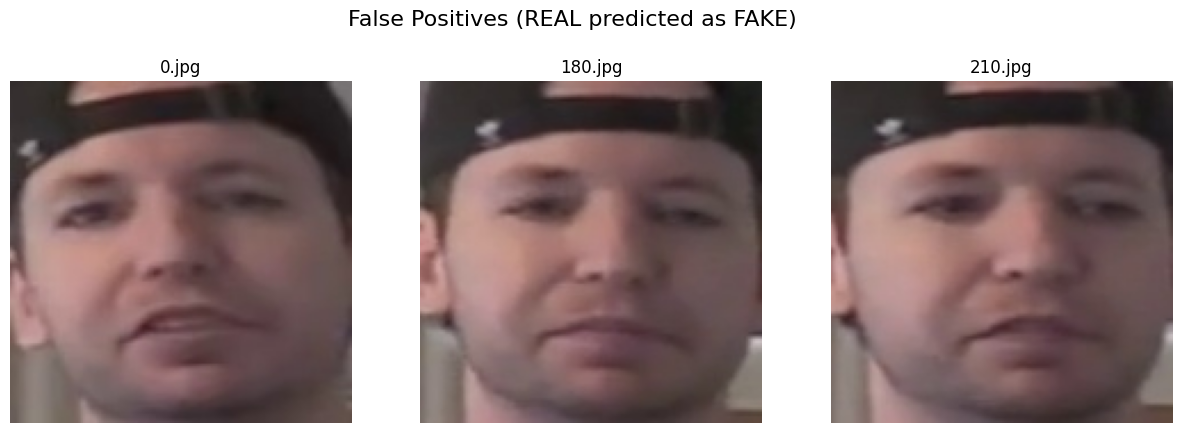

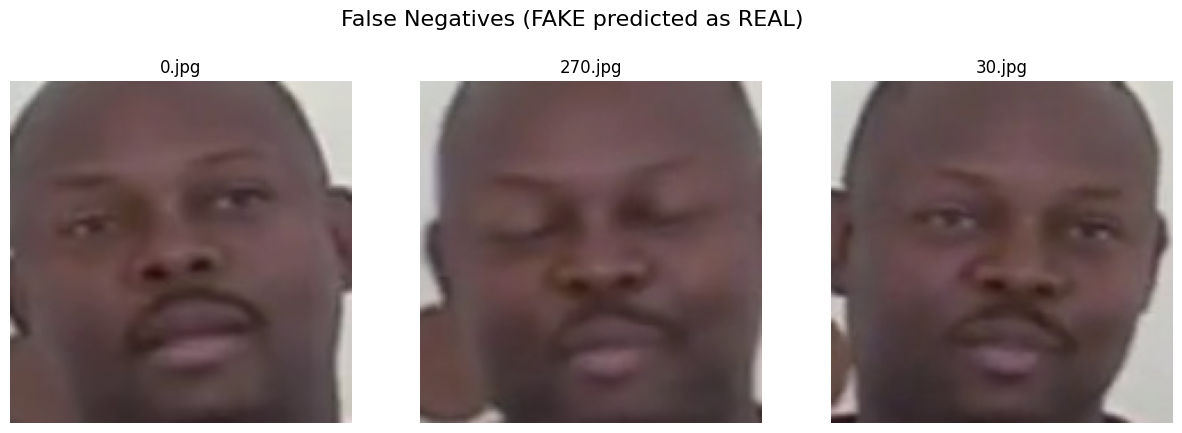

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_efficientnet_model(num_classes=2, freeze_base=False):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes)
    )
    if freeze_base:
        for param in model.features.parameters():
            param.requires_grad = False
    return model

model = get_efficientnet_model(num_classes=2, freeze_base=False)
model.load_state_dict(torch.load("../models/b0/F1_0.7630813953488372.pth", map_location=device))
model.to(device)
model.eval()

test_df = pd.read_csv("../data/test_data.csv")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

fp_images = []
fn_images = []

for _, row in test_df.iterrows():
    label = 0 if row["label"] == "REAL" else 1
    video_id = row["filename"]
    frame_dir = f"../data/images/{video_id}"
    if not os.path.exists(frame_dir):
        continue

    frame_paths = sorted(glob(f"{frame_dir}/*.jpg"))
    for img_path in frame_paths:
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()

        if label == 0 and pred == 1 and len(fp_images) < 3:
            fp_images.append(img_path)
        elif label == 1 and pred == 0 and len(fn_images) < 3:
            fn_images.append(img_path)

        if len(fp_images) >= 3 and len(fn_images) >= 3:
            break


def show_images(img_list, title):
    fig, axes = plt.subplots(1, len(img_list), figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i, img_path in enumerate(img_list):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(img_path))
    plt.show()

show_images(fp_images, "False Positives (REAL predicted as FAKE)")
show_images(fn_images, "False Negatives (FAKE predicted as REAL)")
